In [1]:
!pip3 install torch torchvision

How to modified the model:
If the model is not fit and classify data well, we can:

-First, change learning rate, higher learning rate a bit.

-Second, add more convolutional layers

-Third, Data Augmentation

**Importing Relevant Libraries:**

In [0]:
import torch
#torchvision is a standard package which contain lots of datasets include MNIST dataset.It also consists of transformations, transformations are commonly 
#applied to these images in order to pre-process them before fit into a neural network.
from torchvision import datasets, transforms 
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F

**Initializing GPU Usage**

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

**Load Training and Validation Dataset, Transformations, Loader**

In [6]:
transform_train = transforms.Compose([
                                transforms.Resize((32,32)),
                                #Data Augmentation: given more variety
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10), #10 is the angle
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                transforms.ColorJitter(brightness = 0.2, contrast=0.2, saturation=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5],[0.5])]) #Normalize, set value 0.5 since we want the range 0 - 1 change to range -1 - 1.


#transforms.Compose means to chain transformations together. transforms.ToTensor() will convert the numpy array in the range of 0-255 to a float tensor in
#the range 0-1 encode in a tensor shape (Channel, Height, Width). transforms.Normalize() will normalized the values for each tensor of image size channel height
#and width. The first bracket is mean=0.5, second bracket is s.d.=0.5.
transform = transforms.Compose([
                                transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5],[0.5])]) #Normalize, set value 0.5 since we want the range 0 - 1 change to range -1 - 1.

#In CIFAR10 dataset, each image is 32*32 color image.
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform = transform_train)#transform dictates any image manipulations that you wish to apply on the images.
#training_dataset

validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)

#loader image
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True) 
#Since batch_size=100, we have total of 60000 training set, it will take roughly 600 iteration to complete one epoch. It will update the weight of neural network for each iteration to minimize the error.
#Remember to shuffle the training data before each epoch.

validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False) #validation_loader is only for testing purposes, not have to 
#shuffle, since it's not use to train the model, it instead use for testing the model.

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomAffine(degrees=(0, 0), scale=(0.8, 1.2), shear=(-10, 10))
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

**Numpy Image Conversion Function**

In [0]:
#Since we want to plot the image use matplotlib, we need to convert the image from tensor into numpy array.
#tensor.clone makes a new copy of the tensor. image.transpose(color channel, width, height)
#thus the color channel = 3, the shape now is (3,32,32). To plot the image, we required (32,32,3) shape. Thus swap the first one to be the last one...
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  #print(image.shape)
  
  #denormalize
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))  #normalize = (x-mean)/sd   denormalize = (x*sd)+mean
  image = image.clip(0,1) #previously, we have range between -1 and 1, now change the range between 0 and 1 use clip().
  return image



In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

**Plotting Image Data**

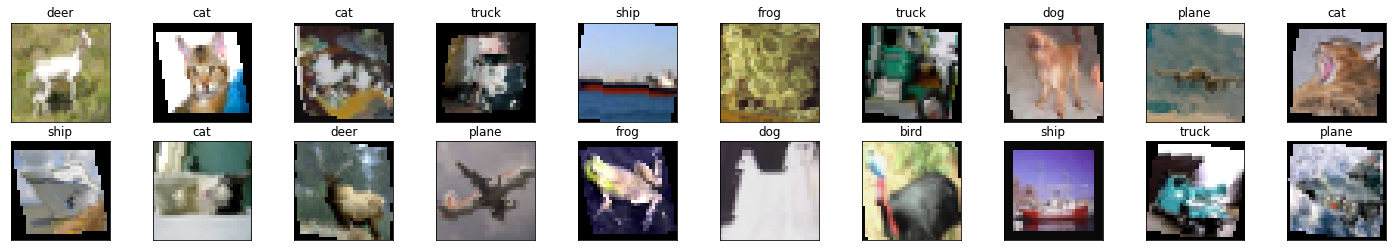

In [0]:
dataiter = iter(training_loader) 
images, labels = dataiter.next() ##Go through the training loader and access one element at a time by calling next(). Like it will grab the first batch of our training data. And split into images and labels for that training data.
fig = plt.figure(figsize=(25,4)) #specify the width and height of the figure.

for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[]) #2 rows, 10 columns, start at index 1 which (idx+1).
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])


**Model Class Constructor**

In [0]:
#Create Custom CNN Model:
#Setting model constructor
class LeNet(nn.Module):
  def __init__(self): 
    super().__init__()
    #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
    #in_channels (int) – Number of channels in the input image. out_channels (int) – Number of channels produced by the convolution. kernel_size (int or tuple) – Size of the convolving kernel
    self.conv1 = nn.Conv2d(3,16,3,1, padding=1) #Define Convolution Layer. 
    self.conv2 = nn.Conv2d(16,32,3,1,padding=1)
    self.conv3 = nn.Conv2d(32,64,3,1,padding=1)
    #First we start with a depth of 1 (grayscale image with only 1 channel, then we move to a depth of 20)
    self.fc1 = nn.Linear(4*4*64,500) #Fully Connected Layer
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500,10)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2) #max_pooling layer. First argument is feed forward x value. Next two arguments define the size of max pooling kernel which we 
    #use 2*2 kernel to cut the image size in half, but still maintain effective feature extraction.
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x,2,2)
    x = x.view(-1, 4*4*64) #We will flatten before going to fully connected layer. 4*4*50 is number of rows
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x


In [0]:
model = LeNet().to(device)
model



LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
#Loss function in our model
criterion = nn.CrossEntropyLoss() #This loss function used for multiclass classification.
#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #lr is learning rate
#Learning rate is important, too high learning rate will lead to lower accuracy, low learning rate will can help a neural network learn more effective. 
#But at the same time, a learning rate is too small can significantly slow down the training performance.

In [0]:
#specify number of epochs
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs) #contain bunch of score values and it follows the class wich contains the highest score by passing it into the softmax.
    loss = criterion(outputs, labels) #Compare predicted outputs and labels and determine error base on CrossEntropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1) #preds is return the index of the maximum value for that image.
    running_loss += loss.item() #The current loss at batch iteration
    running_corrects += torch.sum(preds == labels.data) #See how many got correct


  else: #the else statement will start after for loop finish which means we iterated through every single batch of images.
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
         val_inputs = val_inputs.to(device)
         val_labels = val_labels.to(device)
         val_outputs = model(val_inputs)
         val_loss = criterion(val_outputs, val_labels)

         _, val_preds = torch.max(val_outputs, 1)
         val_running_loss += val_loss.item() 
         val_running_corrects += torch.sum(val_preds == val_labels.data)
   
    
  


    epoch_loss = running_loss/len(training_loader) #print accumulated loss that's compute for the entire dataset at the specific epoch. Average loss for epoch
    #len(training_loader) = 600. 
    epoch_acc = running_corrects.float()/len(training_loader) #average accuracy for that epoch
    running_loss_history.append(epoch_loss) #Since keep track loss in every single epoch
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))


epoch : 1
training loss: 1.6977, acc 37.3400
validation loss: 1.3892, validation acc 49.0500
epoch : 2
training loss: 1.3946, acc 49.4880
validation loss: 1.2569, validation acc 54.3200
epoch : 3
training loss: 1.2800, acc 53.9400
validation loss: 1.1383, validation acc 59.3600
epoch : 4
training loss: 1.1853, acc 57.6920
validation loss: 1.0670, validation acc 61.7800
epoch : 5
training loss: 1.1242, acc 59.9800
validation loss: 1.0440, validation acc 62.5900
epoch : 6
training loss: 1.0774, acc 61.9700
validation loss: 0.9923, validation acc 64.8200
epoch : 7
training loss: 1.0370, acc 63.1520
validation loss: 0.9723, validation acc 65.1600
epoch : 8
training loss: 1.0071, acc 64.5840
validation loss: 0.9163, validation acc 68.1400
epoch : 9
training loss: 0.9689, acc 66.0060
validation loss: 0.9039, validation acc 67.9600
epoch : 10
training loss: 0.9509, acc 66.5040
validation loss: 0.8718, validation acc 69.6900
epoch : 11
training loss: 0.9301, acc 67.2980
validation loss: 0.8581

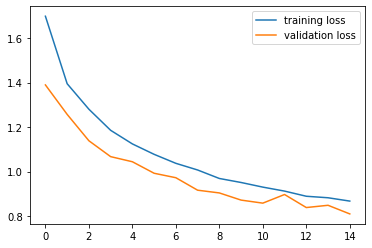

In [0]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label = 'validation loss')
plt.legend()

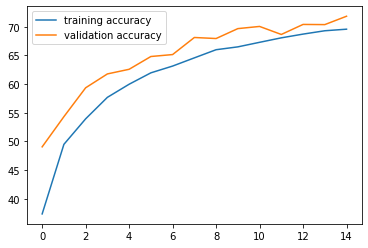

In [0]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'validation accuracy')
plt.legend()

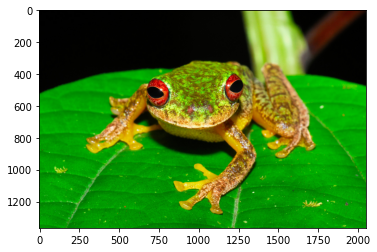

In [0]:
#Test our model by grab a image from the web
import requests
from PIL import Image #PIL is Python Image Library
url = 'https://static01.nyt.com/images/2019/04/02/science/28SCI-ZIMMER1/28SCI-ZIMMER1-superJumbo.jpg'
response = requests.get(url,stream=True) #retrieve image
img = Image.open(response.raw) #identify the raw contents of the response variable
plt.imshow(img)
#print(response)

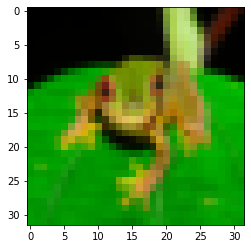

In [0]:
#preprocess image
import PIL.ImageOps 
img = transform(img) #Inside transform there is a resize which change the range of image to 28*28.
plt.imshow(im_convert(img))

In [0]:
image = img.to(device).unsqueeze(0)
output = model(image) #result a score
_, pred = torch.max(output, 1) #take class with highest score
print(classes[pred.item()])


frog


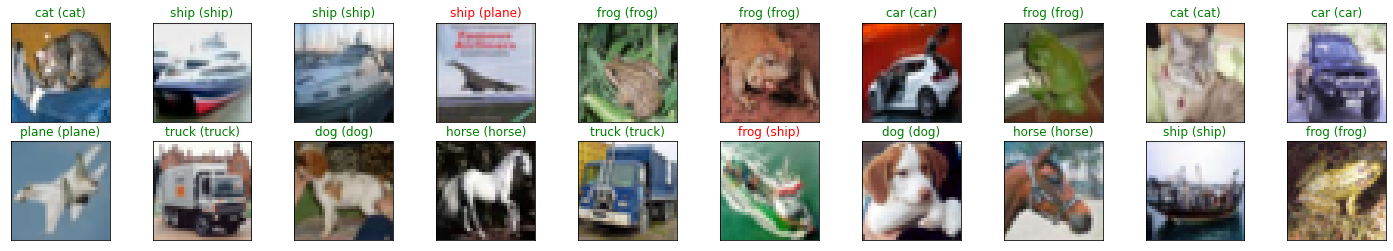

In [0]:
dataiter = iter(validation_loader) 
images, labels = dataiter.next() 
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[]) #2 rows, 10 columns, start at index 1 which (idx+1).
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx] == labels[idx] else "red"))